## Point training et avancement (avec des images)

<br/>
Jeudi matin nous avons convenus avec Pierre-Henri Conze qu'il fallait essayer d'obtenir des résultats exploitables. Notre problème de fond étant toujours la capacité de calcul. En effet, avec les scanners de tailles (96,96,128) donc de taille réduite par rapport aux originaux (224,160,192) nous n'avons toujours des temps d'entrainements extrêmement long notamment lors de la vectorisation des données (10 minutes par epoques). Cela nous force à entrainer un réseau de taille réduite : 

- encoder, decoder originaux : [[16, 32, 32, 32],[32, 32, 32, 32, 32, 16, 16]]
- encoder, decoder réduits:[[16, 32, 32],[32, 16, 16]]

<br/>
de plus cela nous force également à entrainer le réseau sur un nombre réduit de scanners (100 répartis en 30 scanners de validations et 70 scanners d'entraînements) et ce, sans effectuer des transformations affines ou autres (comme dans le notebook monai). 
<br/>
Pour rappel nous entraînons sur les GPU accessibles par l'école (8 giga de GPU), nous sommes régulièrement déconnecté de nos sessions ce qui interrompt et donc ralentit encore les entraînements.
<br/>

#### Visualisations pre-training
<br/>
Voici quelques scanners ainsi que les masques de segmentations associés avant un training

shape scanner : (96, 96, 128)


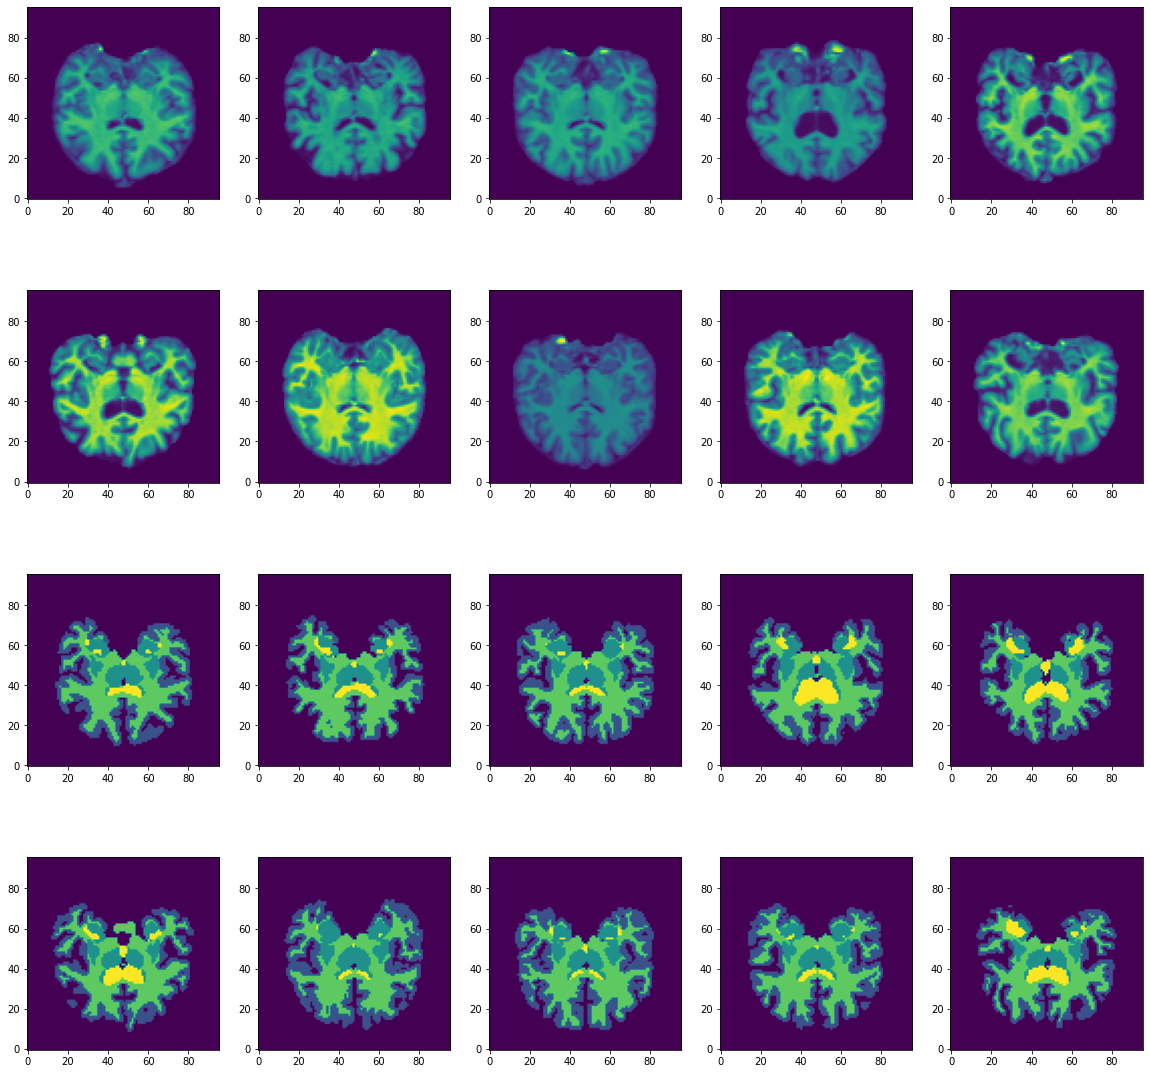

In [1]:
from Dataloaders.MRI_loader import load, get_labels_list, get_data_dicts
from config import dataloader_config
from process.utils import show_scanner


partition=get_data_dicts(dataloader_config['rootdir'],dataloader_config['valid_ratio'])
list_image,list_mask=[],[]
for i in range(10):
    image,_,mask,__=load(partition['train'][i],partition['train'][i],vectorize=False)
    list_image.append(image)
    list_mask.append(mask)

print("shape scanner : {}".format(image.shape))

show_scanner(list_image+list_mask)


### Training sans vectorisations 
<br/>

- Courbe d'erreur et de Dice
- Visualisations de champs et d'images recalées

<br/>

#### Loss et Dice
<br/>
La convergence de la loss est très rapide, le Dice se stabilise également très vite ce qui nous pousse à penser que le réseau ne s'entraine plus après un nombre d'époques trop court. 
<br/> 
Nous verrons le même phénomène pour les données vectorisées mais en encore moins bien ce qui pourrait nous mener à conclure que la vectorisation n'est pas concluante (cf résultats Training avec vectorisation).

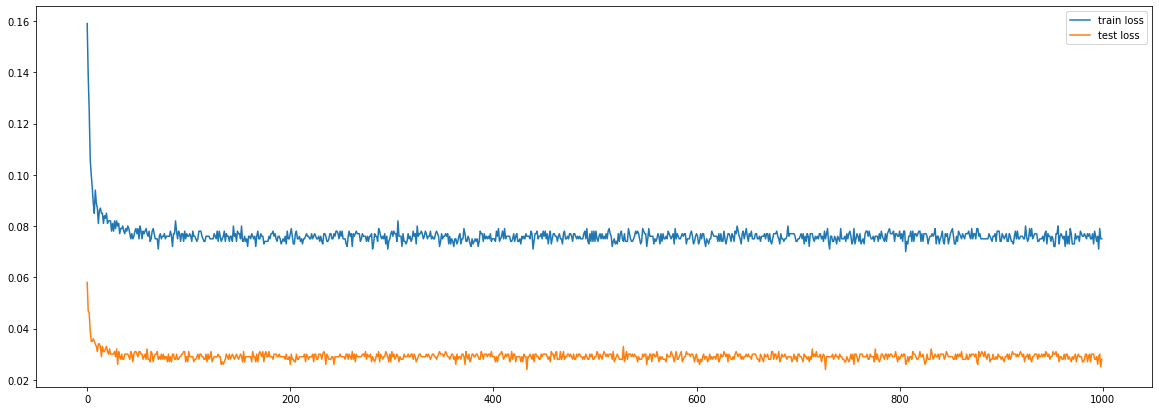

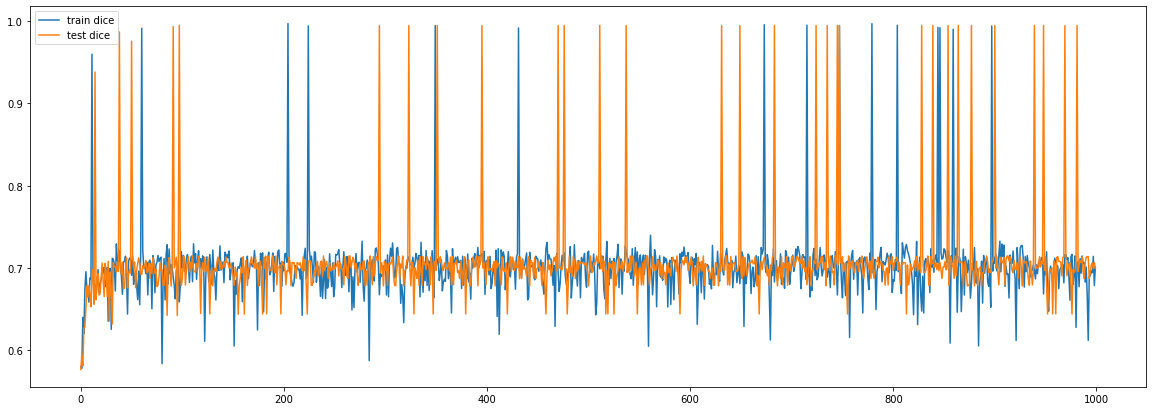

In [2]:
from process.utils import loss_recovery, Dice_recovery

loss_recovery('./training/training_stan.out')
test=Dice_recovery('./training/training_stan.out')

#### Images recalées et champs

In [ ]:
from main import evaluate
from config import model_config, dataloader_config, train_config, criterion_config, scheduler_config
model_state_dict_path="path"
trained_model = evaluate(model_state_dict_path, model_config, dataloader_config, train_config, criterion_config, scheduler_config)

In [ ]:
#loading two scan for visualization
from Dataloaders.registration_loader import get_dataloaders
import torch

fixed_image,moving_image,fixed_mask,moving_mask=next(iter(trainer.testloader))
fixed_image, moving_image = fixed_image.to(trainer.model.device), moving_image.to(trainer.model.device)
moving_mask = moving_mask.to(trainer.model.device)

with torch.no_grad():
            #fixed_image_mask, moving_image_mask = fixed_image_mask.to(self.model.device), moving_image_mask.to(self.model.device)
            pred_image, flow_field = trainer.model.net(moving_image.float(),fixed_image.float())
            pred_mask = trainer.model.net.transformer(moving_mask.float(), flow_field)
            loss, train_mean_dice = trainer.model.criterion(pred_image, pred_mask.detach().cpu(), fixed_image, fixed_mask, flow_field)
            
fixed_image,moving_image,fixed_mask,moving_mask=fixed_image.detach().cpu().numpy(),moving_image.detach().cpu().numpy(),fixed_mask.detach().cpu().numpy(),moving_mask.detach().cpu().numpy()
pred_image, flow_field, pred_mask = pred_image.detach().cpu().numpy(), flow_field.detach().cpu().numpy(), pred_mask.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(fixed_image[:,:,64])
plt.title("fixed_image")
plt.subplot(1, 4, 2)
plt.imshow(fixed_mask[:,:,64])
plt.title("fixed_mask")
plt.subplot(1, 4, 3)
plt.imshow(pred_image[:,:,64])
plt.title("pred_image")
plt.subplot(1, 4, 4)
plt.imshow(pred_mask[:,:,64])
plt.title("pred_mask")

plt.show()

### Training avec vectorisations 
<br/>

- Vectorisation
- Courbe d'erreur et de Dice
- Visualisations de champs et d'images recalées

<br/>

#### Vectorisation
<br/>
Pour rappel le code source des fonctions liés à la vectorisations des scanners est situé dans le fichier utils.py (lui-même situé dans le dossier process).
On plot ici une slice du champ de vecteur selon les composantes vectorielles en x et en y.

shape sans vect.. :(96, 96, 128)
shape avec vect.. :(96, 96, 128, 3)


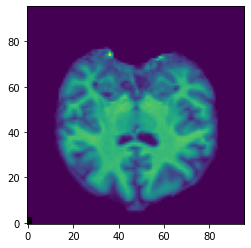

In [2]:
from process.utils import to_vector, plot_vector_field

image, mask=list_image[0], list_mask[0]
print("shape sans vect.. :{}".format(image.shape))
image_vect=to_vector(image)
print("shape avec vect.. :{}".format(image_vect.shape))

show_scanner(image)

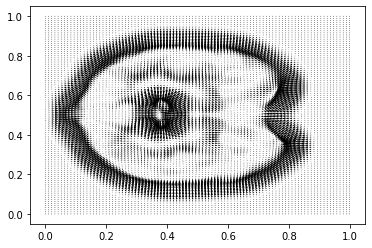

In [3]:
plot_vector_field(image_vect)

#### Loss et Dice
<br/>
Comme ci-dessus la convergence de la loss est très rapide, le Dice se stabilise également très vite mais plus bas que les données non vectorisées.
Ici on est seulement à xx epoques mais on observe déjà bien la convergence (11 minutes par époques, pour 300 et quelques c'est plus de 3 jours d'entrainements).

In [ ]:
from process.utils import loss_recovery, Dice_recovery

loss_recovery('path')
test=Dice_recovery('path')

#### Visualisations de champs et d'images recalées

In [ ]:
dataloader_config['vectorize']=True
model_config['src_feats']=3
model_config['trg_feats']=3

model_state_dict_path="path"
trained_model = evaluate(model_state_dict_path, model_config, dataloader_config, train_config, criterion_config, scheduler_config)

In [ ]:
#loading two scan for visualization
from Dataloaders.registration_loader import get_dataloaders
import torch

fixed_image,moving_image,fixed_mask,moving_mask=next(iter(trainer.testloader))
fixed_image, moving_image = fixed_image.to(trainer.model.device), moving_image.to(trainer.model.device)
moving_mask = moving_mask.to(trainer.model.device)

with torch.no_grad():
            #fixed_image_mask, moving_image_mask = fixed_image_mask.to(self.model.device), moving_image_mask.to(self.model.device)
            pred_image, flow_field = trainer.model.net(moving_image.float(),fixed_image.float())
            pred_mask = trainer.model.net.transformer(moving_mask.float(), flow_field)
            loss, train_mean_dice = trainer.model.criterion(pred_image, pred_mask.detach().cpu(), fixed_image, fixed_mask, flow_field)
            
fixed_image,moving_image,fixed_mask,moving_mask=fixed_image.detach().cpu().numpy(),moving_image.detach().cpu().numpy(),fixed_mask.detach().cpu().numpy(),moving_mask.detach().cpu().numpy()
pred_image, flow_field, pred_mask = pred_image.detach().cpu().numpy(), flow_field.detach().cpu().numpy(), pred_mask.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(fixed_image[:,:,64])
plt.title("fixed_image")
plt.subplot(1, 4, 2)
plt.imshow(fixed_mask[:,:,64])
plt.title("fixed_mask")
plt.subplot(1, 4, 3)
plt.imshow(pred_image[:,:,64])
plt.title("pred_image")
plt.subplot(1, 4, 4)
plt.imshow(pred_mask[:,:,64])
plt.title("pred_mask")

plt.show()